## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Data Exploration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

Images are divided up into vehicles and non-vehicles.

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


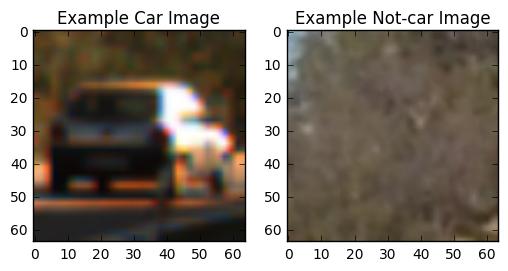

In [2]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
%matplotlib inline
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ', data_info["image_shape"], ' and data type:', data_info["data_type"])

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
# Plot car_not_car
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Histogram of Oriented Gradients (HOG)

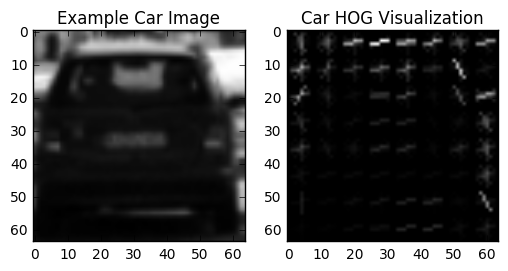

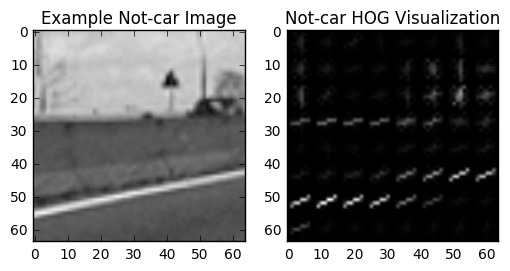

In [24]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, True, False)
image0 = mpimg.imread(notcars[ind])
gray0 = cv2.cvtColor(image0, cv2.COLOR_RGB2GRAY)
_, hog_image0 = get_hog_features(gray0, orient, pix_per_cell, cell_per_block, True, False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('Car HOG Visualization')
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray0, cmap='gray')
plt.title('Example Not-car Image')
plt.subplot(122)
plt.imshow(hog_image0, cmap='gray')
plt.title('Not-car HOG Visualization')

## Concatenated Features

In [4]:
from sklearn.preprocessing import StandardScaler

def bin_spatial(img, size=(16, 16)):
    features = cv2.resize(img, size).ravel()
    return features

def color_hist(img, nbins=16, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_features(imgs, cspace='YCrCb', spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256), hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        if hog_feat:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, False, True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, False, True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

## Extraction and Normalization

8792 8968 6108 6108


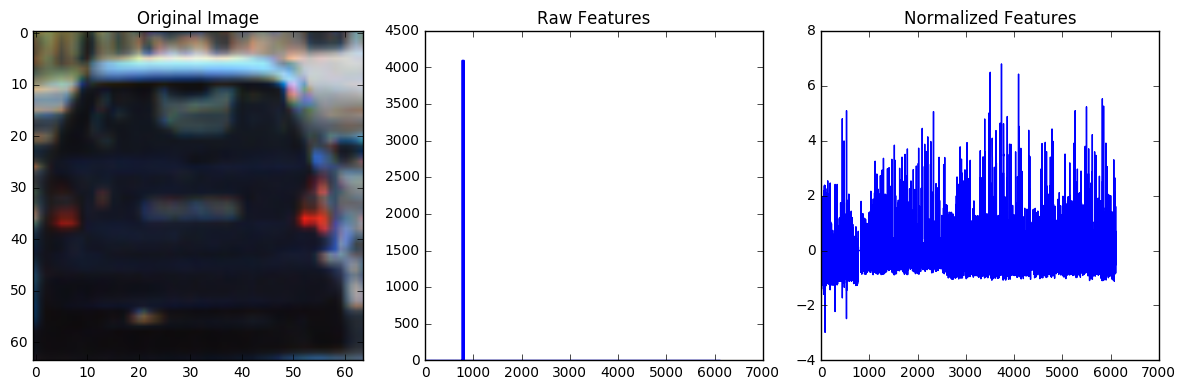

In [5]:
car_features = extract_features(cars, cspace='YCrCb', spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='YCrCb', spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256))
print (len(car_features), len(notcar_features), len(car_features[0]), len(notcar_features[0]))
if len(car_features) > 0:
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else:
    print('Your function only returns empty feature vectors...')

## Linear SVM

In [6]:
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

from sklearn.cross_validation import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)
import time
from sklearn.svm import LinearSVC
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t = time.time()
print('My SVC predicts: ', svc.predict(X_test[:10]))

print('For labels: ', y_test[:10])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict 10 labels with SVC')

/root/miniconda3/envs/carnd_term_1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


59.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
For labels:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
0.06415 Seconds to predict 10 labels with SVC


## Sliding Window Search

In [7]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [25]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*xy_overlap[0])
    ny_buffer = np.int(xy_window[1]*xy_overlap[1])
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

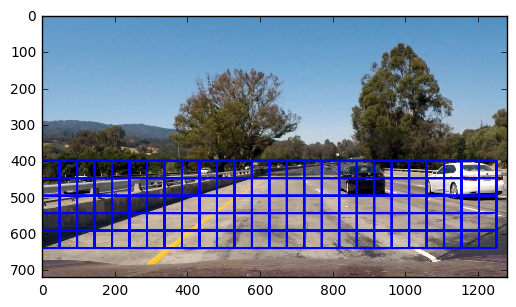

In [28]:
image = mpimg.imread('test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 656], xy_window=(96, 96))
window_img = draw_boxes(image, windows)
plt.imshow(window_img)

Helper functions

In [12]:
def single_img_features(img, color_space='YCrCb', spatial_size=(16, 16), hist_bins=16, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='YCrCb', spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, 
                  hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

## Search and Classify

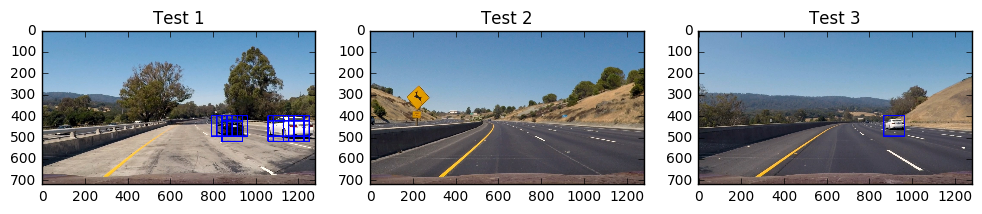

In [34]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(16,16), hist_bins=16):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    on_windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
        
    nxblocks = ch1.shape[1]//pix_per_cell - 1
    nyblocks = ch1.shape[0]//pix_per_cell - 1
    nfeat_per_block = orient*cell_per_block**2
        
    window = 64
    nblocks_per_window = window//pix_per_cell - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window)//cells_per_step
    nysteps = (nyblocks - nblocks_per_window)//cells_per_step
        
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
                
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
                
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+ystart+win_draw))
                on_windows.append(bbox)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+ystart+win_draw),(0,0,255),6)
    return draw_img, on_windows

ystart = 400
ystop = 656
scale = 1.5

out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size=(16,16), hist_bins=16)
image2 = mpimg.imread('test_images/test2.jpg')
out_img2, _ = find_cars(image2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
image3 = mpimg.imread('test_images/test3.jpg')
out_img3, _ = find_cars(image3, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(out_img)
plt.title('Test 1')
plt.subplot(132)
plt.imshow(out_img2)
plt.title('Test 2')
plt.subplot(133)
plt.imshow(out_img3)
plt.title('Test 3')

## Heat Map

In [15]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

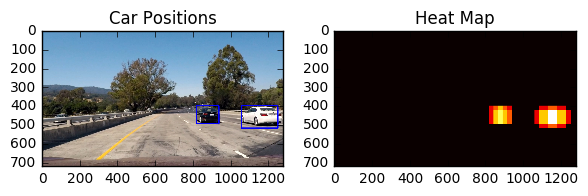

In [16]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,bbox_list)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

2 cars found


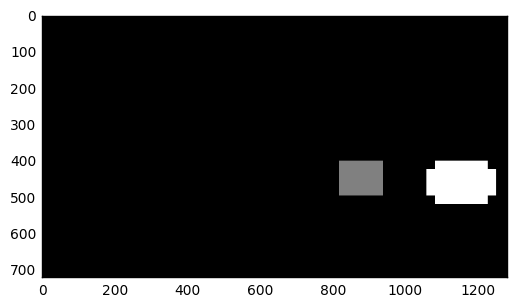

In [35]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

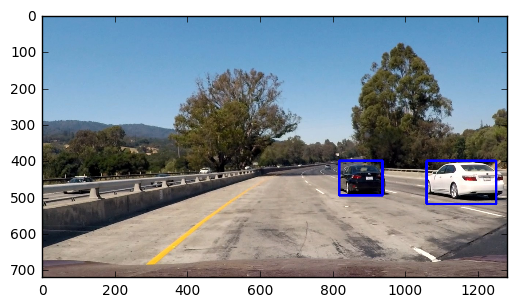

In [36]:
plt.imshow(draw_img)

## Video

In [17]:
def processing(image):
    global boxes
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    _, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    boxes.append(bbox_list)
    if len(boxes) > 10:
        boxes = boxes[-10:]
    heat = add_heat(heat,[bbox for box in boxes for bbox in box])
    heat = apply_threshold(heat,5)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
boxes = []
clip = VideoFileClip('project_video.mp4')
output = clip.fl_image(processing)
%time output.write_videofile('output_project_video.mp4', audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [07:45<00:00,  3.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 7min 24s, sys: 0 ns, total: 7min 24s
Wall time: 7min 46s
